In [1]:
import os
import cv2
import glob
import pickle
import numpy as np
from tqdm import tqdm
from keras.utils import normalize
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from matplotlib.patches import Rectangle
from sklearn.metrics import average_precision_score

SIZE_X = 128
SIZE_Y = 128
n_channels = 3
n_classes = 10
Batch_size = 8
EPOCHS = 100
MODEL = 'segnet'
BACKBONE = 'Vanilla CNN'
parent_directory = r'E:\Segmentation\datasets\FloodNet-Supervised_v1.0'

In [2]:
def load_images(parent_directory, split='train'):
    images = []
    masks = [] 

    image_folder_path = f'{parent_directory}\{split}\{split}-org-img'
    for img_path in tqdm(glob.glob(os.path.join(image_folder_path, "*.jpg"))):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        images.append(img)

        mask_path = (img_path.replace('org', 'label')).replace('jpg', 'png')
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        masks.append(mask)
                
    images = np.array(images)
    masks = np.array(masks)

    print(f'{split.upper()}: Images loaded: {images.shape[0]}')
    print(f'{split.upper()}: Masks loaded: {masks.shape[0]}')

    return images, masks

In [9]:
def preprocess_data(images, masks, unet_preporcessing=None):
    if unet_preporcessing:
        images = unet_preporcessing(images)
    else:
        images = normalize(images, axis=1)
        
    masks = np.expand_dims(masks, axis=-1)
    masks = to_categorical(masks, num_classes=n_classes)
    masks = masks.reshape((masks.shape[0], -1, n_classes))

    return images, masks

def reverse_masks_shape(masks):
    masks = masks.reshape((masks.shape[0], SIZE_X, SIZE_Y, n_classes))
    return masks

In [4]:
class_map= {'Background':0, 'Building-flooded':1, 'Building-non-flooded':2, 'Road-flooded':3, 'Road-non-flooded':4, 'Water':5, 'Tree':6, 'Vehicle':7, 'Pool':8, 'Grass':9}
    
color_map = {'Background':[0, 0, 0], 'Building-flooded':[196, 0, 0], 'Building-non-flooded': [255,128,128], 'Road-flooded':[128, 128, 0],  'Road-non-flooded':[128, 128, 128], 
                 'Water': [0, 191, 255], 'Tree':[34, 139, 34], 'Vehicle': [123, 37, 118],  'Pool':[0, 68, 255],'Grass':[127, 224, 104]}

handles = [Rectangle((0,0),1,1, color = (np.array(c)/255)) for n,c in color_map.items()]

labels = [n for n,c in color_map.items()]


def to_RGB(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """    
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    for key, val in class_map.items():
      label_seg [np.all(label == class_map[key],axis=-1)] = color_map[key]  
    return label_seg

def display_images_with_masks(image, mask, predicted):
    plt.figure(figsize=(12, 8))
    plt.subplot(131)
    plt.title('Testing Image')
    plt.imshow(image)
    plt.subplot(132)
    plt.title('Testing Label')
    plt.imshow(to_RGB(np.tile(np.expand_dims(mask, axis=-1), (1, 1, 3)))) 
    plt.subplot(133)
    plt.title('Prediction')
    plt.imshow(to_RGB(np.tile(np.expand_dims(predicted, axis=-1), (1, 1, 3))))
    plt.legend(handles, labels, bbox_to_anchor =(-0.8,-0.5), loc='lower center', ncol=5)
    plt.show()

In [ ]:
#Load the images
train_images, train_masks = load_images(parent_directory, split='train')
val_images, val_masks = load_images(parent_directory, split='val')

In [6]:
data_to_save = {
    'train_images': train_images,
    'train_masks': train_masks,
    'val_images': val_images,
    'val_masks': val_masks
}

pickle_file_path = '../../dataset/train_and_val_data.pickle'

with open(pickle_file_path, 'wb') as pickle_file:
    pickle.dump(data_to_save, pickle_file)

print(f'Data saved to {pickle_file_path}')

print('Shapes of loaded data:')
print('Train Images:', train_images.shape)
print('Train Masks:', train_masks.shape)
print('Val Images:', val_images.shape)
print('Val Masks:', val_masks.shape)

Data saved to ../../dataset/train_and_val_data.pickle
Shapes of loaded data:
Train Images: (1445, 128, 128, 3)
Train Masks: (1445, 128, 128)
Val Images: (450, 128, 128, 3)
Val Masks: (450, 128, 128)


In [10]:
pickle_file_path = '../../dataset/train_and_val_data.pickle'

with open(pickle_file_path, 'rb') as pickle_file:
    loaded_data = pickle.load(pickle_file)

train_images = loaded_data['train_images']
train_masks = loaded_data['train_masks']
val_images = loaded_data['val_images']
val_masks = loaded_data['val_masks']

print('Shapes of loaded data:')
print('Train Images:', train_images.shape)
print('Train Masks:', train_masks.shape)
print('Val Images:', val_images.shape)
print('Val Masks:', val_masks.shape)

Shapes of loaded data:
Train Images: (1445, 128, 128, 3)
Train Masks: (1445, 128, 128)
Val Images: (450, 128, 128, 3)
Val Masks: (450, 128, 128)


In [11]:
train_images, train_masks = preprocess_data(train_images, train_masks)
val_images, val_masks = preprocess_data(val_images, val_masks)

print('Shapes of loaded data:')
print('Train Images:', train_images.shape)
print('Train Masks:', train_masks.shape)
print('Val Images:', val_images.shape)
print('Val Masks:', val_masks.shape)

Shapes of loaded data:
Train Images: (1445, 128, 128, 3)
Train Masks: (1445, 16384, 10)
Val Images: (450, 128, 128, 3)
Val Masks: (450, 16384, 10)


In [12]:
from keras_segmentation.models.all_models import unet, pspnet, fcn, segnet
import segmentation_models as sm

model = None

if MODEL == 'unet':
    if BACKBONE == 'Vanilla Mini CNN':
        model = unet.unet_mini(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'Vanilla CNN':
        model = unet.unet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'ResNet-50':
        model = unet.resnet50_unet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'VGG-16':
        model = unet.vgg_unet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'MobileNet':
        model = unet.mobilenet_unet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
elif MODEL == 'pspnet':
    if BACKBONE == 'Vanilla CNN':
        model = pspnet.pspnet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'Vanilla CNN (50)':
        model = pspnet.pspnet_50(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'Vanilla CNN (101)':
        model = pspnet.pspnet_101(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'ResNet-50':
        model = pspnet.resnet50_pspnet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'VGG-16':
        model = pspnet.vgg_pspnet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
elif MODEL == 'segnet':
    if BACKBONE == 'Vanilla CNN':
        model = segnet.segnet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'ResNet-50':
        model = segnet.resnet50_segnet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'VGG-16':
        model = segnet.vgg_segnet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'MobileNet':
        model = segnet.mobilenet_segnet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
else:
    raise ValueError('Unknown model')

if model:
    model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
    model.summary()
else:
    print('Model not found')

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 zero_padding2d_10 (ZeroPadd  (None, 130, 130, 3)      0         
 ing2D)                                                          
                                                                 
 conv2d_11 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization_10 (Bat  (None, 128, 128, 64)     256       
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 64)       0   

In [13]:
history = model.fit(x=train_images, y=train_masks, batch_size=Batch_size, epochs=EPOCHS, validation_data=(val_images, val_masks))

Epoch 1/100
181/181 [==============================] - 14s 50ms/step - loss: 0.9889 - iou_score: 0.3948 - val_loss: 3.8136 - val_iou_score: 0.0650
Epoch 2/100
181/181 [==============================] - 7s 39ms/step - loss: 0.7144 - iou_score: 0.4748 - val_loss: 1.4580 - val_iou_score: 0.1193
Epoch 3/100
181/181 [==============================] - 7s 39ms/step - loss: 0.6837 - iou_score: 0.4981 - val_loss: 1.1357 - val_iou_score: 0.3503
Epoch 4/100
181/181 [==============================] - 7s 40ms/step - loss: 0.6381 - iou_score: 0.5313 - val_loss: 0.6585 - val_iou_score: 0.5232
Epoch 5/100
181/181 [==============================] - 8s 46ms/step - loss: 0.6091 - iou_score: 0.5508 - val_loss: 0.9008 - val_iou_score: 0.4465
Epoch 6/100
181/181 [==============================] - 7s 40ms/step - loss: 0.5900 - iou_score: 0.5649 - val_loss: 2.9704 - val_iou_score: 0.0851
Epoch 7/100
181/181 [==============================] - 7s 39ms/step - loss: 0.5759 - iou_score: 0.5785 - val_loss: 1.1668 -

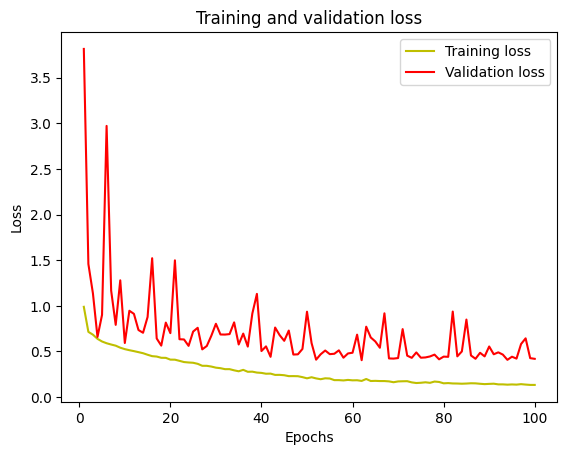

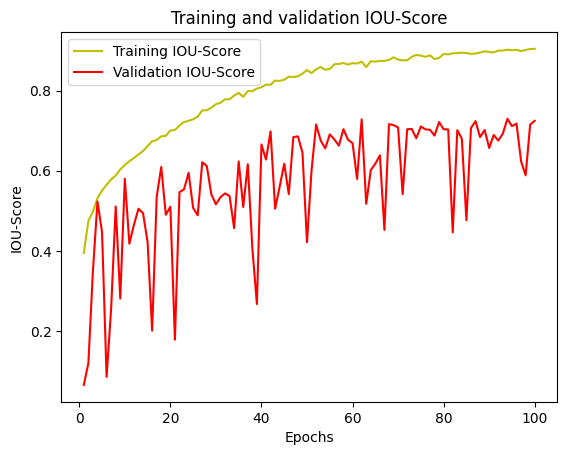

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU-Score')
plt.plot(epochs, val_acc, 'r', label='Validation IOU-Score')
plt.title('Training and validation IOU-Score')
plt.xlabel('Epochs')
plt.ylabel('IOU-Score')
plt.legend()
plt.show()

In [15]:
model.save(f'weights/{MODEL.upper()}_model_with_{EPOCHS}_epochs({MODEL.upper()}_{BACKBONE.capitalize()}).hdf5')

In [9]:
model.load_weights(f'weights/{MODEL.upper()}_model_with_{EPOCHS}_epochs({MODEL.upper()}_{BACKBONE.capitalize()}).hdf5')

In [23]:
test_images, test_masks = load_images(parent_directory, split='test')
test_images_seperate = test_images

test_images, test_masks = preprocess_data(test_images, test_masks)

100%|██████████| 448/448 [02:24<00:00,  3.09it/s]

TEST: Images loaded: 448
TEST: Masks loaded: 448


In [24]:
data_to_save = {
    'test_images': test_images,
    'test_masks': test_masks,
    'test_images_seperate': test_images_seperate
}

pickle_file_path = '../../dataset/test_data.pickle'

with open(pickle_file_path, 'wb') as pickle_file:
    pickle.dump(data_to_save, pickle_file)

print(f'Data saved to {pickle_file_path}')

print('Shapes of loaded data:')
print('Test Images:', test_images.shape)
print('Test Masks:', test_masks.shape)

Data saved to ../dataset/test_data.pickle
Shapes of loaded data:
Test Images: (448, 128, 128, 3)
Test Masks: (448, 128, 128, 10)


In [16]:
pickle_file_path = '../../dataset/test_data.pickle'

with open(pickle_file_path, 'rb') as pickle_file:
    loaded_data = pickle.load(pickle_file)

test_images = loaded_data['test_images']
test_masks = loaded_data['test_masks']
test_images_seperate = loaded_data['test_images_seperate']

test_images, test_masks = preprocess_data(test_images, test_masks)

print('Shapes of loaded data:')
print('Test Images:', test_images.shape)
print('Test Masks:', test_masks.shape)

Shapes of loaded data:
Test Images: (448, 128, 128, 3)
Test Masks: (448, 16384, 10)


In [17]:
_, acc = model.evaluate(test_images, test_masks, verbose=0)
print("Accuracy is = ", (acc * 100.0), "%")

Accuracy is =  71.47044539451599 %


In [18]:
from keras.metrics import MeanIoU
import numpy as np

y_pred = model.predict(test_images)

print('Before Predicted and Actual Masks Shapes:')
print(y_pred.shape)
print(test_masks.shape) 

predicted_masks = reverse_masks_shape(y_pred)
test_masks = reverse_masks_shape(test_masks)

print('Reshaping Predicted and Actual Masks Shapes:')
print(predicted_masks.shape)
print(test_masks.shape) 

print('Final Predicted and Actual Masks Shapes:')
predicted_masks = np.argmax(predicted_masks, axis=-1)
test_masks_ = np.argmax(test_masks, axis=-1)

14/14 [==============================] - 1s 39ms/step
Before Predicted and Actual Masks Shapes:
(448, 16384, 10)
(448, 16384, 10)
Reshaping Predicted and Actual Masks Shapes:
(448, 128, 128, 10)
(448, 128, 128, 10)
Final Predicted and Actual Masks Shapes:


In [19]:
class_names = ["Background", "Building Flooded", "Building Non-Flooded", "Road Flooded", "Road Non-Flooded",
               "Water", "Tree", "Vehicle", "Pool", "Grass"]

n_classes = len(class_names)  
IOU_keras = MeanIoU(num_classes=n_classes)

IOU_keras.update_state(test_masks_, predicted_masks)
print("Mean IoU =", IOU_keras.result().numpy())

values = np.array(IOU_keras.get_weights())
values = values.reshape(n_classes, n_classes)

class_IoUs = []
print("IoU for each class:")
for i in range(n_classes):
    if i == 0: 
        continue
    class_IoU = values[i, i] / (np.sum(values[i, :]) + np.sum(values[:, i]) - values[i, i])
    class_IoUs.append(class_IoU)
    print(f"{class_names[i]}: {class_IoU}")

mean_IoU_without_background = np.mean(class_IoUs)
print("Mean IoU (excluding Background):", mean_IoU_without_background)

Mean IoU = 0.44412914
IoU for each class:
Building Flooded: 0.4426214396953583
Building Non-Flooded: 0.5481693744659424
Road Flooded: 0.38964298367500305
Road Non-Flooded: 0.6202857494354248
Water: 0.6681777238845825
Tree: 0.6580172181129456
Vehicle: 0.004304920788854361
Pool: 0.12033756822347641
Grass: 0.8112062811851501
Mean IoU (excluding Background): 0.47364038


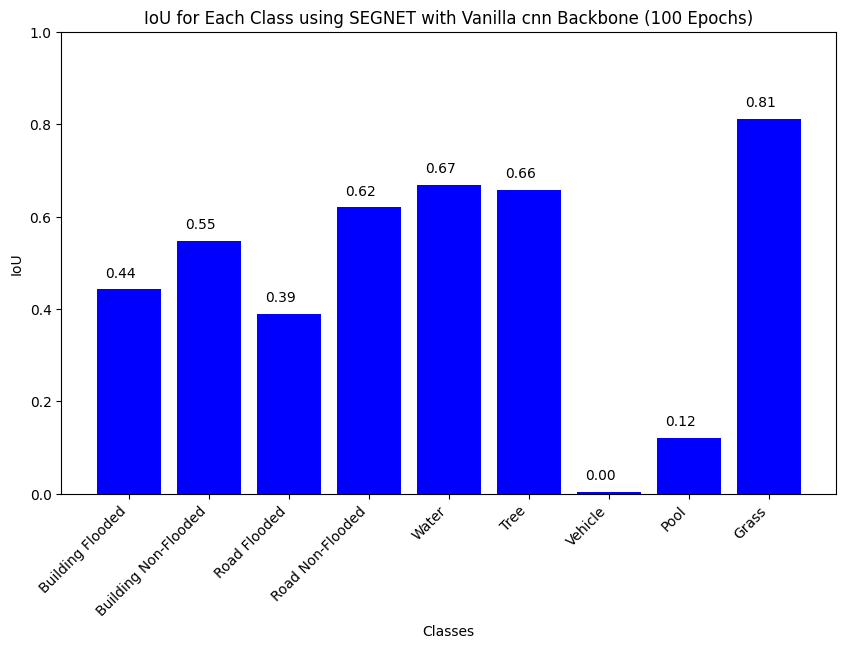

In [20]:
plt.figure(figsize=(10, 6))
bars = plt.bar(class_names[1:], class_IoUs, color='blue')
plt.title(f'IoU for Each Class using {MODEL.upper()} with {BACKBONE.capitalize()} Backbone ({EPOCHS} Epochs)')
plt.xlabel('Classes')
plt.ylabel('IoU')
plt.ylim(0, 1) 
plt.xticks(rotation=45, ha='right')  

for bar, value in zip(bars, class_IoUs):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.02, f'{value:.2f}', ha='center', va='bottom')

plt.show()

In [21]:
def display_random_function():
    image_id = np.random.randint(0, len(test_images))
    image = test_images_seperate[image_id]
    ground_truth_mask = test_masks_[image_id]
    predicted_mask = predicted_masks[image_id]

    print(f'Image Shape: {image.shape}')
    print(f'Ground Truth Mask Shape: {ground_truth_mask.shape}')
    print(f'Predicted Mask Shape: {predicted_mask.shape}')

    display_images_with_masks(image, ground_truth_mask, predicted_mask)

Image Shape: (128, 128, 3)
Ground Truth Mask Shape: (128, 128)
Predicted Mask Shape: (128, 128)


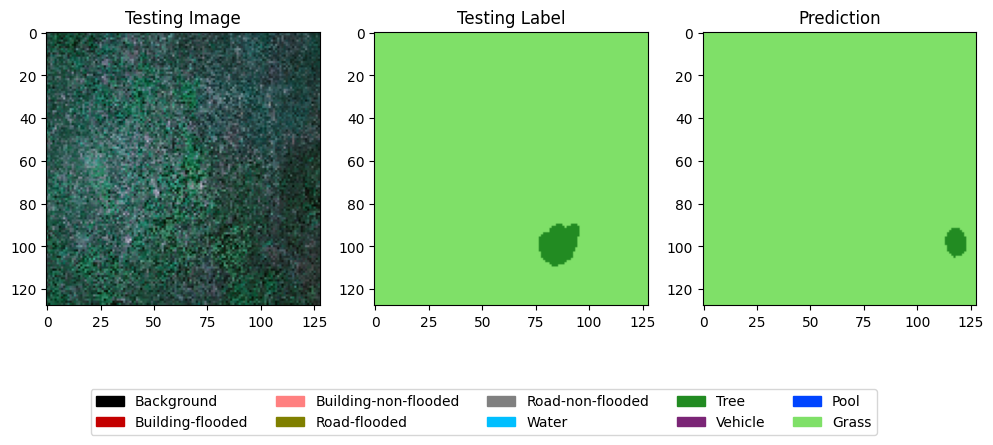

In [22]:
display_random_function()

Image Shape: (128, 128, 3)
Ground Truth Mask Shape: (128, 128)
Predicted Mask Shape: (128, 128)


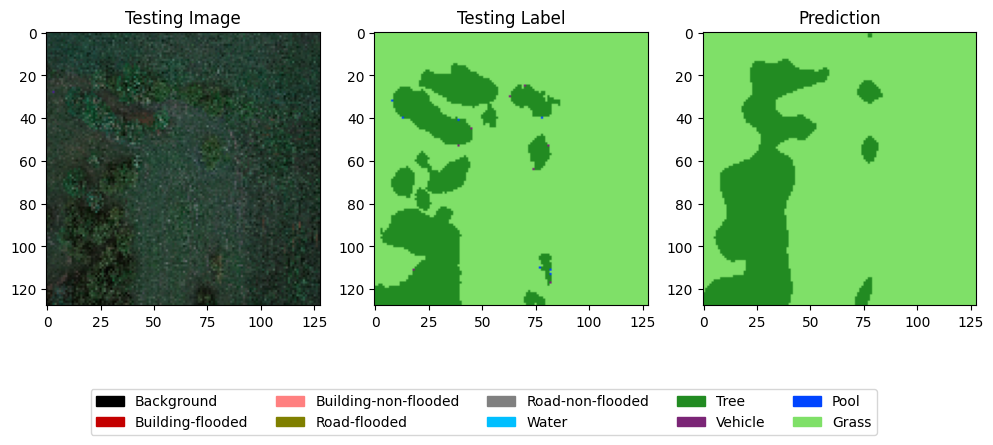

In [23]:
display_random_function()

Image Shape: (128, 128, 3)
Ground Truth Mask Shape: (128, 128)
Predicted Mask Shape: (128, 128)


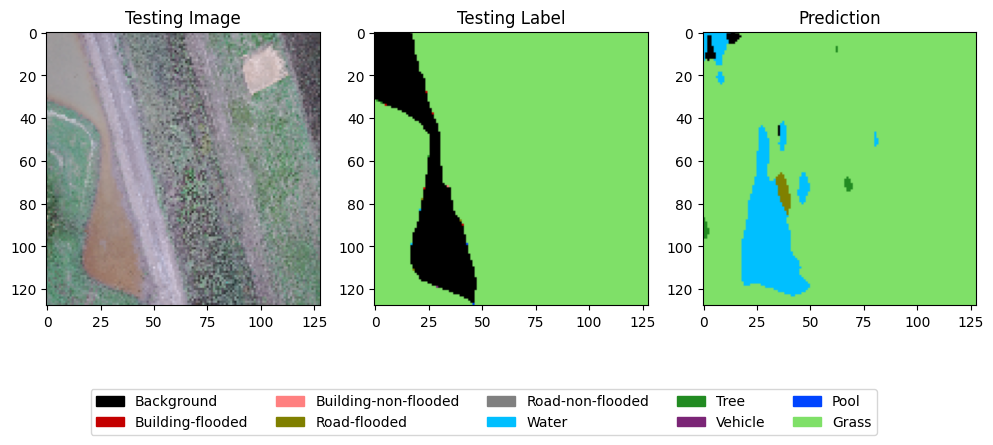

In [24]:
display_random_function()

Image Shape: (128, 128, 3)
Ground Truth Mask Shape: (128, 128)
Predicted Mask Shape: (128, 128)


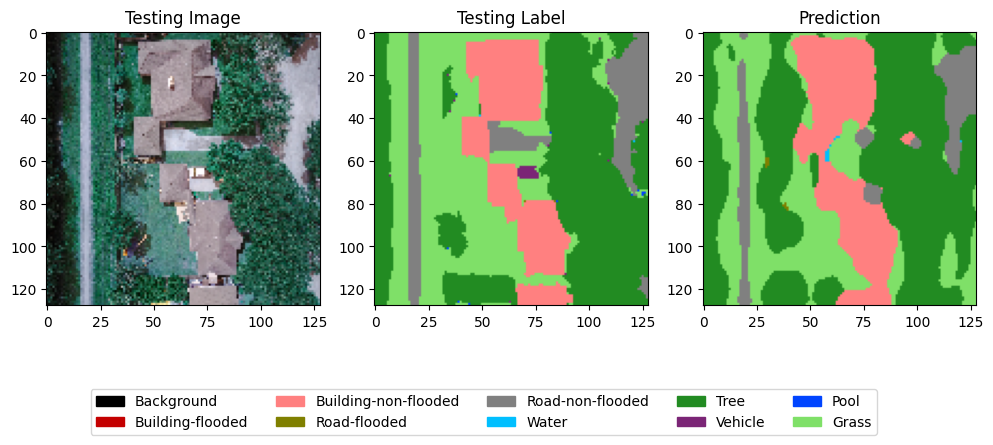

In [25]:
display_random_function()

Image Shape: (128, 128, 3)
Ground Truth Mask Shape: (128, 128)
Predicted Mask Shape: (128, 128)


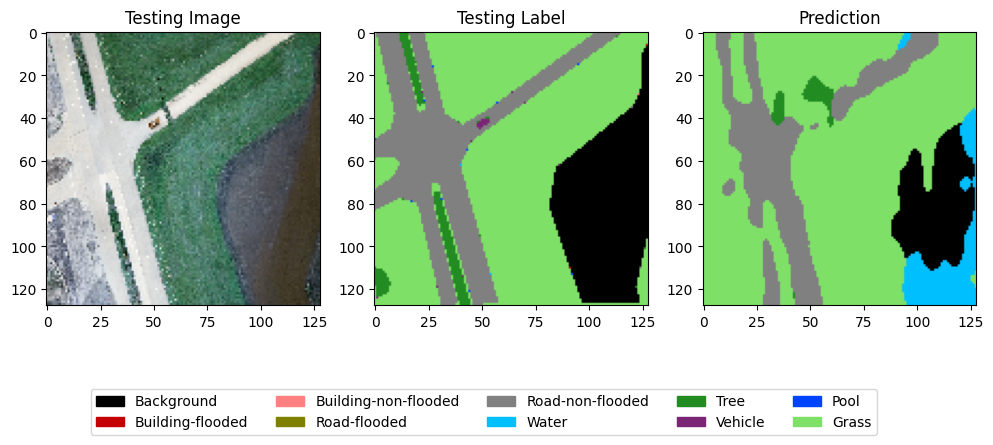

In [26]:
display_random_function()